# [Computational Social Science] Project 4: Unsupervised Learning

Group Number: NA

Group Members: Corrine Aramburo

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


In [3]:
nhanes_scaled.shape

(2064, 242)

## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

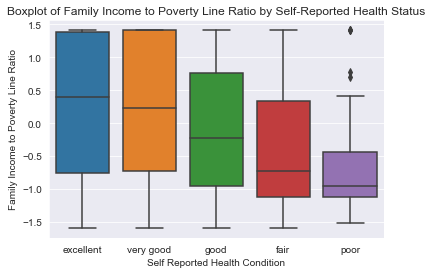

In [4]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

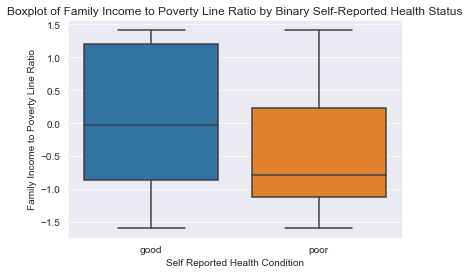

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

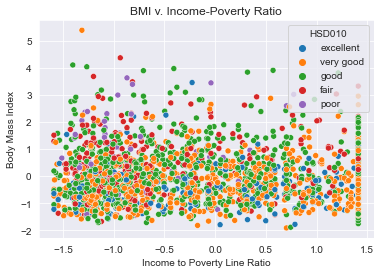

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

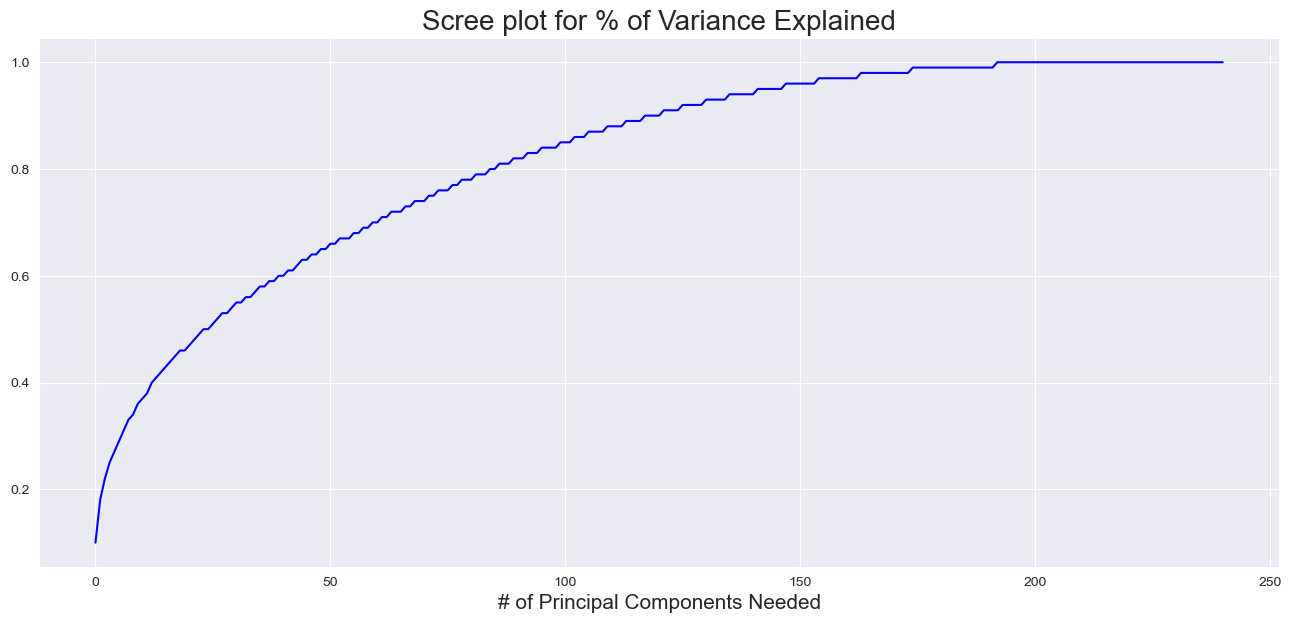

In [8]:
#Plotting a scree plot to see how many principal components would be needed to capture the a good amount 
#of the variance in the data set 

#create a scree plot with no principal components assgined
pca = PCA()
principalComponents_nhanes1 = pca.fit_transform(nhanes_scaled)
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum().round(2)
fig, axes = plt.subplots(1,1, figsize = (16,7), dpi = 100)
plt.plot(variance_exp_cumsum, color = "blue")
plt.title("Scree plot for % of Variance Explained", fontsize = 20)
plt.xlabel("# of Principal Components Needed", fontsize = 15)
plt.show()

It appears that the first few features don't explain much of the variance (~20%). From the scree plot, it 
seems that to capture 90% of the variance we would need ~125 principal components out of the 240 features and to get 95% of the variance we need at least 150 principal components. I will use 125 principal components 
for the following section to see if it makes sense to reduce the components further. 

In [9]:
#train PCA on 125 components to capture ~90% of the variance of the data set 
pca_125 = PCA(n_components = 125)
principalComponents_nhanes = pca_125.fit_transform(nhanes_scaled)


In [10]:
features = range(pca_125.n_components_)
pca_final_125 = pd.DataFrame(data = principalComponents_nhanes, columns = features)


In [11]:
pca_final_125.head()

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,9.527811,-0.816224,-1.867092,-2.109911,-3.929391,-0.185272,-3.845173,-2.934723,1.514160,0.682644,...,0.853523,-0.378159,0.758261,0.868229,-0.347055,-0.726790,0.387748,1.831720,-0.434136,0.046961
1,-5.838339,-3.692573,3.805750,-1.029672,0.394557,1.593189,2.711061,-0.740647,0.384814,-2.406107,...,-0.904325,-1.016017,1.676015,-1.290809,-0.219275,1.066725,-0.699037,-0.795855,0.805253,-0.851395
2,-0.719454,-2.573200,0.907904,-4.755850,-1.798871,0.863632,-1.024458,0.633000,0.542102,0.449340,...,0.674302,-0.171410,-0.201204,-0.293521,0.577848,0.167005,-0.293575,0.787374,0.813347,-0.479614
3,3.533627,-2.576982,-3.249125,-0.405435,3.999030,1.444517,-1.182103,0.326791,-4.151316,-1.245347,...,0.168751,-0.765807,0.842176,-0.602290,1.234340,-0.193760,-0.228004,-1.224849,-0.124570,-0.349308
4,-6.872094,-4.194241,0.886831,-0.848951,-0.524829,0.073108,0.843741,0.987899,0.556911,-0.044667,...,0.931726,-0.137591,0.226739,-0.871048,-0.232608,-0.620052,-0.822225,0.793676,-0.425370,0.415320


### Barplot of Components
Before plotting the components, I wanted to see exactly how much the varaince was explained for each of the 125 principal components and then adding them up to see total variance. The total variance explained by the 125 principal components is 91%. 

In [12]:
print('Explained variation for each of the 125 principal components: {}'.format(pca_125.explained_variance_ratio_))
print('Total variance explained =', sum(pca_125.explained_variance_ratio_))


Explained variation for each of the 125 principal components: [0.10201961 0.07623011 0.04371192 0.02882172 0.02357132 0.0190163
 0.01810852 0.01655592 0.01557116 0.01532197 0.01319964 0.01212789
 0.01157937 0.01155981 0.01110006 0.01004583 0.00943223 0.00932323
 0.00880415 0.00869021 0.00840106 0.00826033 0.00796175 0.00782772
 0.00753777 0.00723654 0.00711078 0.00694053 0.00679369 0.00645715
 0.00639636 0.00631747 0.00621796 0.00617767 0.005928   0.00577463
 0.00568541 0.00563007 0.00561663 0.00555558 0.0054945  0.00543096
 0.0053157  0.00527989 0.005218   0.00516114 0.0051088  0.00501968
 0.00498541 0.00495531 0.00491125 0.00484243 0.00482155 0.00474956
 0.00472077 0.00463783 0.00462434 0.00458705 0.00451238 0.00448758
 0.00447019 0.00438639 0.00437553 0.00433376 0.00429091 0.00426048
 0.00423607 0.00420309 0.00414697 0.00411793 0.00407736 0.00405875
 0.00404242 0.00397882 0.00393902 0.00392989 0.00389884 0.00383848
 0.00379516 0.00377831 0.00373191 0.00370953 0.00367877 0.00366103
 

Though the total variance explained is 91% for the 125 principal components we want to check to see if we need 
all these features or if there is a drop off point, so we can avoid overfiting the data. 
Below we will visualize a bar graph to see the proportion of the variace and then select our final number of 
features to avoid overfitting. 


Text(0, 0.5, 'Variance Explained')

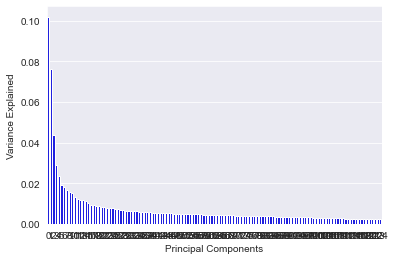

In [13]:
pca_125_final_df = pd.DataFrame({"Variance":pca_125.explained_variance_ratio_,
                                 "Principal Components":features})

sns.barplot(x = "Principal Components", y = "Variance",
            data = pca_125_final_df, color = "b")
plt.xlabel("Principal Components")
plt.ylabel("Variance Explained")

## Your Answer Here

#plot the features = range- list of the number of features 
#plot.bar (features)
#then explained variance 
#then bar plot of the explained variance for the different components 
#explain the variance

### How many components will you use to fit a supervised learning model?

Though the scree plot shows that we would need ~125 principal components to explain 91% of the variance in the data set, looking at the bar graph there is a steep drop off around 50 features. As we can see below, when 50 features were selected and fitted to the model, the total variance explained was ~65%. By plotting another bar graph we see a clear drop off around 16 principal components; however, since this is unsupervised machine learning and we do not know which features are being selected. I will stick with 50 features as dropping down to 16 would remove too much of the information provided by the features in the data set. It may make more sense to go back to 125 features once it is run on a supervised model to capture more of the variance. 

In [14]:
#train PCA on 50 components to capture ~65% of the variance of the data set 
pca_50 = PCA(n_components = 50)
principalComponents_nhanes_1 = pca_50.fit_transform(nhanes_scaled)

In [15]:
features = range(pca_50.n_components_)
pca_final_50 = pd.DataFrame(data = principalComponents_nhanes_1, columns = features)
pca_final_50.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,9.527811,-0.816238,-1.867128,-2.111241,-3.929726,-0.181969,-3.838830,-2.939045,1.501661,0.676329,...,0.553953,0.444549,-0.429291,0.216474,-0.436436,0.779580,-1.005423,-0.289000,0.947352,-0.407149
1,-5.838361,-3.692554,3.806151,-1.028631,0.397442,1.589120,2.691897,-0.723273,0.403174,-2.373405,...,1.978326,-3.392268,-2.133262,3.765046,0.172197,-1.779794,-0.722724,2.037973,-0.066743,0.533035
2,-0.719452,-2.573186,0.907903,-4.756451,-1.798820,0.864035,-1.018501,0.633109,0.539166,0.444076,...,0.804692,0.207204,0.411047,0.201292,0.447358,-0.723205,-0.495744,-0.387776,0.028786,-0.203517
3,3.533630,-2.576972,-3.249137,-0.405589,3.998208,1.443297,-1.179200,0.326430,-4.153444,-1.246884,...,-0.317009,0.061069,0.749328,0.281981,0.109083,0.132272,0.423727,-0.484604,0.298351,0.088019
4,-6.872091,-4.194234,0.886765,-0.849295,-0.526074,0.073692,0.851146,0.976151,0.561322,-0.053209,...,0.343861,0.683886,-0.755119,-1.424005,0.436153,-1.962356,0.429725,0.334578,-0.060465,0.499627


In [16]:
print('Explained variation for each of the 50 principal components: {}'.format(pca_50.explained_variance_ratio_))

print('Total variance explained =', sum(pca_50.explained_variance_ratio_))

Explained variation for each of the 50 principal components: [0.10201961 0.07623011 0.04371192 0.02882171 0.02357131 0.01901627
 0.01810841 0.01655583 0.01557096 0.01532174 0.01319913 0.0121256
 0.01157802 0.01155719 0.01109707 0.01004128 0.00942787 0.00931941
 0.00879411 0.00868076 0.00839379 0.00824143 0.00794673 0.00780621
 0.00750035 0.00720979 0.00706709 0.00687349 0.00673948 0.00641294
 0.00635338 0.00626524 0.00613049 0.00607243 0.00580246 0.00568672
 0.00560908 0.00557121 0.00548008 0.00540932 0.00535684 0.00530322
 0.00518839 0.00510839 0.0050664  0.00500771 0.00494779 0.00483973
 0.00478559 0.0047379 ]
Total variance explained = 0.6476620155806722


Text(0, 0.5, 'Variance Explained')

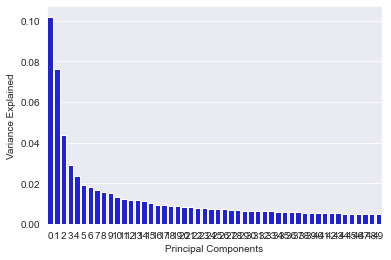

In [17]:
pca_50_final_df = pd.DataFrame({"Variance":pca_50.explained_variance_ratio_,
                                 "Principal Components":features})

sns.barplot(x = "Principal Components", y = "Variance",
            data = pca_50_final_df, color = "b")
plt.xlabel("Principal Components")
plt.ylabel("Variance Explained")


### 2D Scatterplot of the first two components

In [18]:
#Train PCA on the first 2 principal components
pca_2 = PCA(n_components = 2)
principalComponents_nhanes_2 = pca_2.fit_transform(nhanes_scaled)

In [19]:
#Here I add back in the binary variable to get "good" and "poor" and create a data frame for the y variable
#"HSD010_binary," so we can get the binary of "good" and "poor" strings rather than floats
labels_nhanes_scaled = nhanes_scaled.copy()
labels_nhanes_scaled['HSD010_binary'] = hsd010_binary

y_var = pd.DataFrame(data = labels_nhanes_scaled.loc[:,['HSD010_binary']].values)

y_var.tail(10)

,0
2054,good
2055,poor
2056,poor
2057,good
2058,good
2059,good
2060,good
2061,poor
2062,good
2063,good


In [20]:
#Create a dataframe for the first two principal components for the scatter plot
pca_2_df = pd.DataFrame(data = principalComponents_nhanes_2, 
                        columns = ['principal component 1', 'principal component 2'])

pca_2_df.head()

,principal component 1,principal component 2
0,9.527810,-0.816216
1,-5.838338,-3.692575
2,-0.719454,-2.573207
3,3.533627,-2.576977
4,-6.872094,-4.194240


In [21]:
#Concatenate the target feature (HSD010_binary) onto the final data set that has the 
#first 2 principal components
final_pca2_df = pd.concat([pca_2_df, y_var], axis = 1,)
final_pca2_df.head(10)

,principal component 1,principal component 2,0
0,9.527810,-0.816216,good
1,-5.838338,-3.692575,good
2,-0.719454,-2.573207,good
3,3.533627,-2.576977,good
4,-6.872094,-4.194240,good
5,9.658235,-0.753884,good
6,-5.721710,-3.652445,good
7,-0.393309,5.374270,good
8,-0.001067,-2.386485,good
9,4.168627,-2.171790,good


In [22]:
#Label the target feature for the scatterplot below
final_pca2_df.columns = ["Principal Component 1", "Principal Component 2", 
                       "HSD010_binary"]
final_pca2_df.head()



,Principal Component 1,Principal Component 2,HSD010_binary
0,9.527810,-0.816216,good
1,-5.838338,-3.692575,good
2,-0.719454,-2.573207,good
3,3.533627,-2.576977,good
4,-6.872094,-4.194240,good


<Figure size 432x288 with 0 Axes>

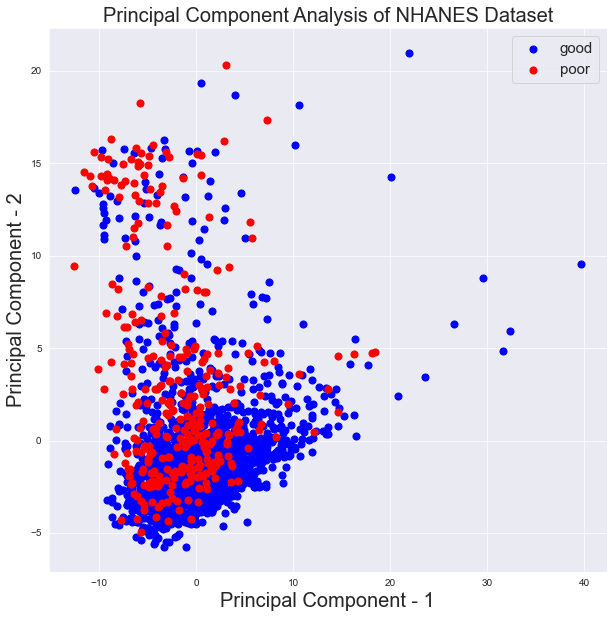

In [23]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES Dataset",fontsize=20)
targets = ['good', 'poor']
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = final_pca2_df["HSD010_binary"] == target
    plt.scatter(final_pca2_df.loc[indicesToKeep, "Principal Component 1"], 
                final_pca2_df.loc[indicesToKeep, "Principal Component 2"],
                c = color, s = 50)
plt.legend(targets,prop={'size': 15})
plt.show()

                

The scatter plot shows that the first two principal components are not well separated, which makes sense since the first two components only explain about 17.8% of the variance (10.2 + 7.6 = 17.8- numbers were pulled from the "explained_variance_ratio_" code above). The scatter plot confirms what was shown in the scree plot and bar graphs, many more features will need to be added to model to capture the information provided in the orignal dataset. Based on the scatterplot, scree plot, and bargraph, I would either go back to the 125 principal component model or 150 (which explains about 95% of the variance in the data) for the machine learning models below. 125 or 150 principal components, though a lot, still elminates half or just under half of the original features (240), so we still capture much of the variance, but don't need to have so many features present in subsequent machine learning models. 

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

In [24]:
## Your Answer Here

### Cluster nhanes

In [25]:
## Your Answer Here

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [26]:
## Your Answer Here

## Your Answer Here

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [27]:
## Your Answer Here

## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [28]:
#y = ... # either hsd010 or hsd010_binary
#X = ... # drop out any columns that aren't features

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [29]:
#import keras
#num_classes = ...
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(..., ...)
#y_test = keras.utils.to_categorical(..., ...)
#num_classes = y_test.shape[1]

In [30]:
#model = Sequential()

#model.add(
    #Dense(..., input_dim= ..., kernel_initializer= ..., activation= ...)


#model.add(
    Dense(..., kernel_initializer= ..., activation= ...)
#)

## Add any additional layers you wish here

#model.compile(loss= ..., optimizer= ..., metrics=[...])

#model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=...)

IndentationError: unexpected indent (<ipython-input-30-de80fc4f97c6>, line 8)

### Neural Network on Principal Components

In [ ]:
## Your Answer Here

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## Your Answer Here

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?
PCA is a method that allows for feature reduction. We look for the smallest number of features that still represents or explains the most variance of the original dataset. Whereas clustering identifies similar features in a data set and then groups them together, but no feature reduction is completed. 


## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"
When working with "big data" we can use unsupervised machine learning techniques in several ways. Given that it might be unruly or infeasible to label large data sets from the onset, unsupervised machine learning can uncover important features and patterns in the data that could not be readily seen. Unsupervised techniques are helpful when it comes to exploratory data analysis (EDA). Even thoguh we don't know spcecific lables or features, we can see patterns and characteristcs in the data, which can help us identify features that represent the original data set, while removing features that may not provide additional or useful information. As mentioned earlier, PCA reduces a set of features that can explain the same amount of variance as the orignal, larger set of features found in the original data set. This feature reduction can assit us downstream with supervised learning tasks by saving us computational time and power. As mentioned with clustering, we can use unsupervised machine learning in the EDA phase to show us patterns not easily seen in the data set especially a set that has a large number of features. These patterns can lead us to different research questions or shift our attention to specific features that may not have been otherwise explored, but could offer important insghts and predictions later down the line. 
